In [65]:
from oauthlib.oauth2 import MissingTokenError

import pandas as pd 
import numpy as np 
import cv2 
import datetime
import os 
from ring_doorbell import Ring, Auth
from pprint import pprint
from pathlib import Path
import getpass
import json
# from datetime import datetime, timedelta
from time import sleep

In [66]:
lst = []
def get_video_length(path:str,
                     lst:list):
    import cv2
    data = cv2.VideoCapture(path)
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = data.get(cv2.CAP_PROP_FPS)
    seconds = round(frames / fps)
    video_time = datetime.timedelta(seconds=seconds)
    lst.append({'path':path,
                'seconds':seconds,
                'fps':fps,
                'video_time':video_time})
    return lst 


vid_path = '../videos/'
videos = [i for i in os.listdir(vid_path) if i.endswith('mp4')]
for video in videos:
    lst = get_video_length(vid_path + video,lst)
df = pd.DataFrame(lst)
df

,path,seconds,fps,video_time
0,../videos/2022-10-26 12_23_02_7158857424823092...,30,24.000000,0 days 00:00:30
1,../videos/2022-10-27 18_25_00_7159321788097201...,8,24.000000,0 days 00:00:08
2,../videos/2022-10-28 17_25_38_7159677574598067...,8,24.000000,0 days 00:00:08
3,../videos/2022-10-30 12_00_59_7160336083278857...,10,24.000000,0 days 00:00:10
4,../videos/2022-11-03 19_42_20_7161939312966076...,9,24.000000,0 days 00:00:09
...,...,...,...,...
206,../videos/2022-10-28 19_19_45_7159706982239143...,6,24.000000,0 days 00:00:06
207,../videos/2022-10-26 20_47_19_7158987377648567...,15,23.932203,0 days 00:00:15
208,../videos/2022-10-27 18_29_41_7159322994983012...,6,24.000000,0 days 00:00:06
209,../videos/2022-10-28 18_31_04_7159694436639671...,6,24.000000,0 days 00:00:06


In [67]:
df = (df
     .assign(date_time=lambda df: pd.to_datetime(df['path'].str.rsplit(' ').str[0].str.split('/').str[2]))
     .set_index('date_time')
     .resample('d')
     .agg({'seconds':'sum',
            'path': pd.Series.nunique,
          })
      .reset_index(drop=False)
      .rename(columns={'seconds':'total_duration',
                       'path':'number_events',
                       })
      .assign(duration_per_event= lambda df: df.total_duration/df.number_events)
    )
df

,date_time,total_duration,number_events,duration_per_event
0,2022-10-24,15,2,7.500000
1,2022-10-25,332,16,20.750000
2,2022-10-26,768,34,22.588235
3,2022-10-27,363,29,12.517241
4,2022-10-28,474,37,12.810811
5,2022-10-29,136,17,8.000000
6,2022-10-30,110,9,12.222222
7,2022-10-31,104,8,13.000000
8,2022-11-01,78,6,13.000000
9,2022-11-02,95,10,9.500000


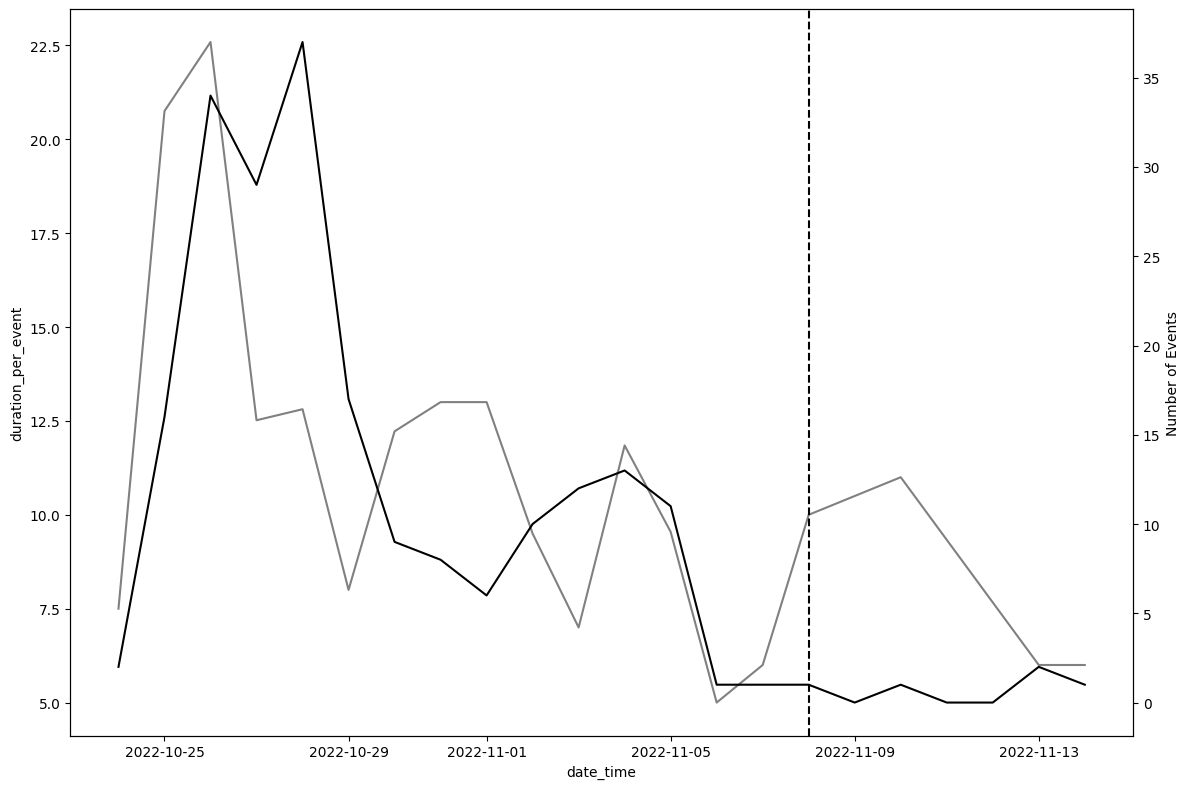

In [68]:
def get_plot(df,
            ):
    import seaborn as sns 
    import matplotlib.pyplot as plt 
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=df,x='date_time',y='duration_per_event',ax=ax,color='grey')

    ax2 = ax.twinx()
    ax2.plot(df['date_time'], df['number_events'], color = 'black')
    ax2.set_ylabel('Number of Events')
    plt.axvline(x = df['date_time'][15], color = 'black',linestyle ="--")
    plt.tight_layout()

    plt.show()
    return None
get_plot(df)

In [ ]:
def token_updated(token):
    cache_file.write_text(json.dumps(token))


def otp_callback():
    auth_code = input("2FA code: ")
    return auth_code

cache_file = Path("test_token.cache")

auth = Auth("Birdie", None, token_updated)
ring = Ring(auth)


try:
    auth.fetch_token(username, password)
except MissingTokenError:
    auth.fetch_token(username, password, otp_callback())

ring.update_data()

devices = ring.devices()

cam = devices['stickup_cams'][0]

events_1 = devices['stickup_cams'][0].history(limit=10000, kind='motion')
events_1


while True:
    try:
        for i in range(0, len(events_1)):
            ident = events_1[i]['id']
            date=events_1[i]['created_at']
            date = date - timedelta(hours=4, minutes=0)
            date=str(date)
            date = date[:19]
            date = date[:13] + "_" + date[14:16] + "_" + date[17:19]
            if i < 3702:
                cam.recording_download(cam.history(limit=10000, 
                                                   kind='motion')[i]['id'],
                                                   filename=f'../videos/{date}_{ident}.mp4',
                                                   override=False)
                print(i)
                

    except:
        last=i
        pass
        
    else:
        break